## Used car price predictions

The objective of this project is to build a Machine Learning model which is able to predict the price of a used car in the UK.

### Import libraries

In [1]:
import sys

print(f"Python's version: {sys.version}")

Python's version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]


In [16]:
import os
import pandas as pd
import seaborn as sns

### Ingest

Source of the dataset: [Kaggle - 100.000 UK Used cars](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes)

In [3]:
# Check list of files
path_data = "./data"
path_data_raw = os.path.join(path_data, "raw")
path_data_interim = os.path.join(path_data, "interim")
path_data_processed = os.path.join(path_data, "processed")

print(os.listdir(path_data_raw))

['audi.csv', 'bmw.csv', 'cclass.csv', 'focus.csv', 'ford.csv', 'hyundi.csv', 'merc.csv', 'skoda.csv', 'toyota.csv', 'unclean cclass.csv', 'unclean focus.csv', 'vauxhall.csv', 'vw.csv']


In [4]:
# We want to import every .csv files except the old versions
# To be ignored: 'cclass.csv', 'focus.csv', 'unclean cclass.csv' & 'unclean focus.csv'
ignored_files = ['cclass.csv', 'focus.csv', 'unclean cclass.csv', 'unclean focus.csv']

brands = {}

for file in os.listdir(path_data_raw):
    if not file in ignored_files:
        brands[file[:-4]] = pd.read_csv(os.path.join(path_data_raw, file))

print(brands.keys())

dict_keys(['audi', 'bmw', 'ford', 'hyundi', 'merc', 'skoda', 'toyota', 'vauxhall', 'vw'])


In [5]:
# Check if all databases have same columns
for brand, brand_data in brands.items():
    print(brand)
    print(brand_data.columns, end="\n\n")

audi
Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

bmw
Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

ford
Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

hyundi
Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType',
       'tax(£)', 'mpg', 'engineSize'],
      dtype='object')

merc
Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

skoda
Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

toyota
Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

vauxhall
Index(['model', 'year', 'price',

In [6]:
# Merge all datasets
brands_data = []

for brand, brand_data in brands.items():
    brand_data['manufacter'] = brand

    # Homogenize 'tax' column for Hyundai
    if brand == 'hyundi':
        brand_data.rename(columns={'tax(£)': 'tax'}, inplace=True)

    brands_data.append(brand_data)

used_vehicles = pd.concat(brands_data, ignore_index=True)
used_vehicles.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,manufacter
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,audi


In [7]:
used_vehicles.shape

(99187, 10)

In [8]:
# Find N/A values
used_vehicles.info(memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99187 entries, 0 to 99186
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         99187 non-null  object 
 1   year          99187 non-null  int64  
 2   price         99187 non-null  int64  
 3   transmission  99187 non-null  object 
 4   mileage       99187 non-null  int64  
 5   fuelType      99187 non-null  object 
 6   tax           99187 non-null  int64  
 7   mpg           99187 non-null  float64
 8   engineSize    99187 non-null  float64
 9   manufacter    99187 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 7.6+ MB


In [9]:
used_vehicles.to_csv(os.path.join(path_data_interim, 'used_vehicles.csv'), index=False)

### Clean

In [10]:
# Correct manufacter value
used_vehicles['manufacter'].replace({'audi': 'Audi', 'bmw': 'BMW', 'ford': 'Ford', 'hyundi': 'Hyundai', 'merc': 'Mercedes', 
                                     'skoda': 'Skoda', 'toyota': 'Toyota', 'vauxhall': 'Vauxhall', 'vw': 'Volkswagen'}, 
                                     inplace=True)

# Strip model of the vehicle
used_vehicles['model'] = used_vehicles['model'].str.strip()
used_vehicles.head()


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,manufacter
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,Audi
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,Audi
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,Audi
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,Audi
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,Audi


In [11]:
difference_percent = 0.2
year_row_pb = used_vehicles.loc[used_vehicles.year == 2060]

# Find similar car
similar_car_pd = used_vehicles.loc[used_vehicles.model == year_row_pb.model.values[0]]
similar_car_pd = similar_car_pd.loc[(similar_car_pd.price >= year_row_pb.price.values[0] * (1 - difference_percent)) &
                                    (similar_car_pd.price <= year_row_pb.price.values[0] * (1 + difference_percent))]
similar_car_pd = similar_car_pd.loc[similar_car_pd.transmission == year_row_pb.transmission.values[0]]
similar_car_pd = similar_car_pd.loc[(similar_car_pd.mileage >= year_row_pb.mileage.values[0] * (1 - difference_percent)) &
                                    (similar_car_pd.mileage <= year_row_pb.mileage.values[0] * (1 + difference_percent))]
similar_car_pd = similar_car_pd.loc[similar_car_pd.fuelType == year_row_pb.fuelType.values[0]]
similar_car_pd = similar_car_pd.loc[(similar_car_pd.tax >= year_row_pb.tax.values[0] * (1 - difference_percent)) &
                                    (similar_car_pd.tax <= year_row_pb.tax.values[0] * (1 + difference_percent))]
similar_car_pd = similar_car_pd.loc[(similar_car_pd.mpg >= year_row_pb.mpg.values[0] * (1 - difference_percent)) &
                                    (similar_car_pd.mpg <= year_row_pb.mpg.values[0] * (1 + difference_percent))]
similar_car_pd = similar_car_pd.loc[similar_car_pd.engineSize == year_row_pb.engineSize.values[0]]                    

similar_car_pd


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,manufacter
38524,Fiesta,2009,5290,Automatic,53000,Petrol,200,43.4,1.4,Ford
38729,Fiesta,2010,5495,Automatic,59000,Petrol,200,43.4,1.4,Ford
39175,Fiesta,2060,6495,Automatic,54807,Petrol,205,42.8,1.4,Ford
39180,Fiesta,2010,5995,Automatic,55000,Petrol,195,42.8,1.4,Ford


In [12]:
# Based on the previous table, the year 2060 is replaced by 2010
used_vehicles.loc[used_vehicles.year == 2060, 'year'] = 2010
used_vehicles.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,manufacter
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,Audi
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,Audi
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,Audi
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,Audi
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,Audi


### EDA

What is the impact of the manufacter/model to the price ?

array([[<AxesSubplot:title={'center':'Audi'}>,
        <AxesSubplot:title={'center':'BMW'}>,
        <AxesSubplot:title={'center':'Ford'}>],
       [<AxesSubplot:title={'center':'Hyundai'}>,
        <AxesSubplot:title={'center':'Mercedes'}>,
        <AxesSubplot:title={'center':'Skoda'}>],
       [<AxesSubplot:title={'center':'Toyota'}>,
        <AxesSubplot:title={'center':'Vauxhall'}>,
        <AxesSubplot:title={'center':'Volkswagen'}>]], dtype=object)

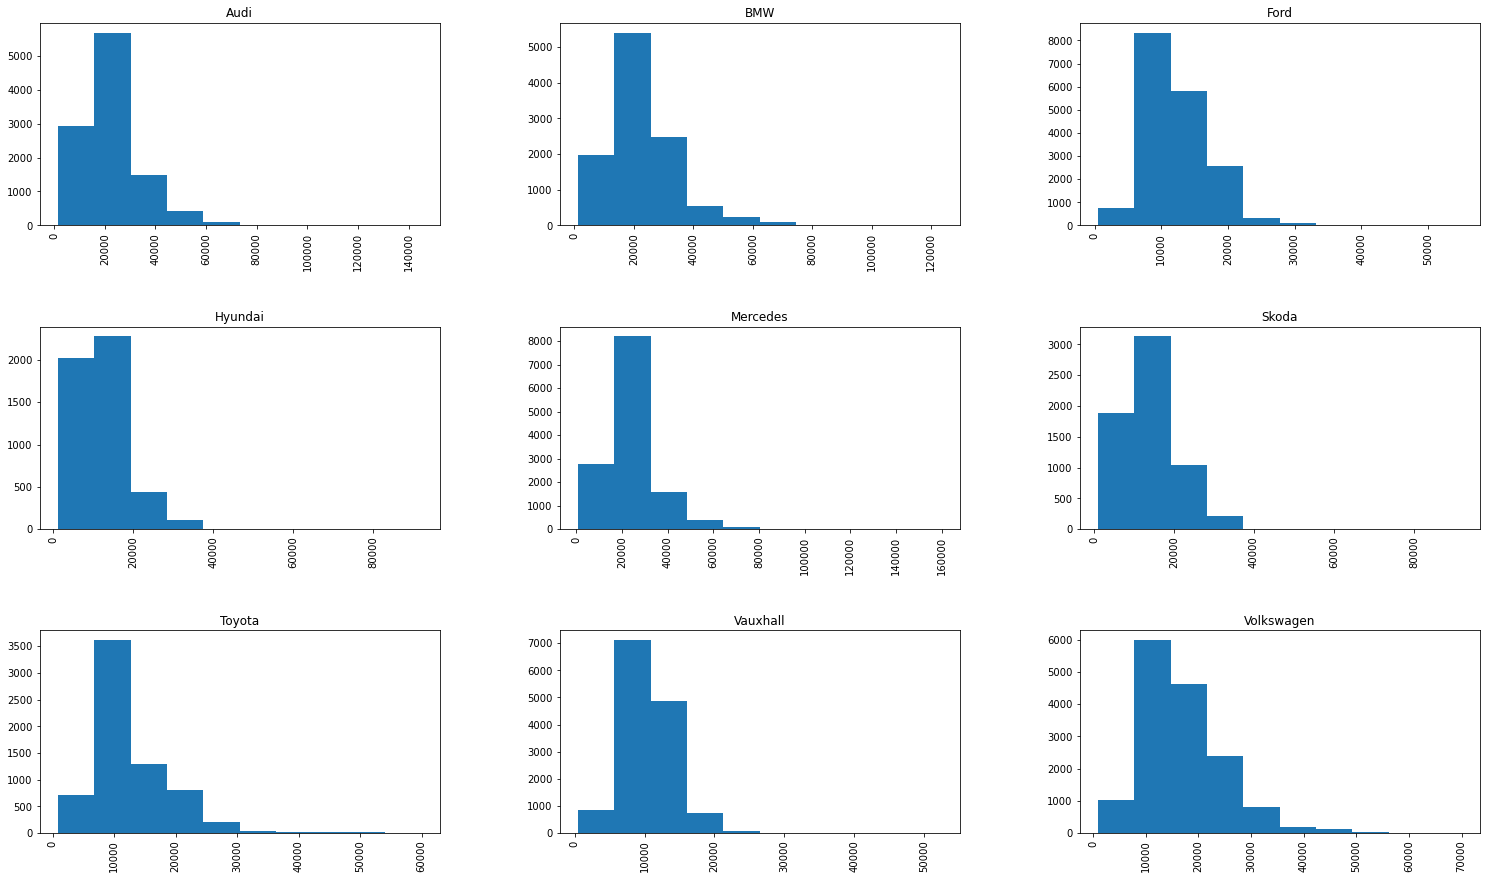

In [15]:
used_vehicles.hist(column='price', by='manufacter', figsize=(25,15))

What is the impact of the year of the price ?

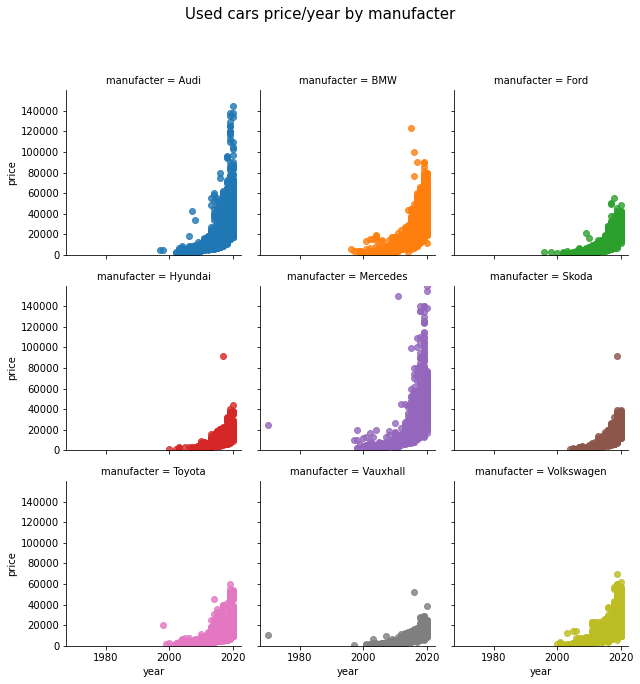

In [20]:
g = sns.FacetGrid(used_vehicles, col='manufacter', col_wrap=3, hue='manufacter')
g.fig.suptitle('Used cars price/year by manufacter', fontsize=15, y=1.05)
g.set(ylim=(0, used_vehicles.price.max()))
g.map(sns.regplot, 'year', 'price')

What is the impact of the transmission ?

C:\Users\Acer\.conda\envs\training\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


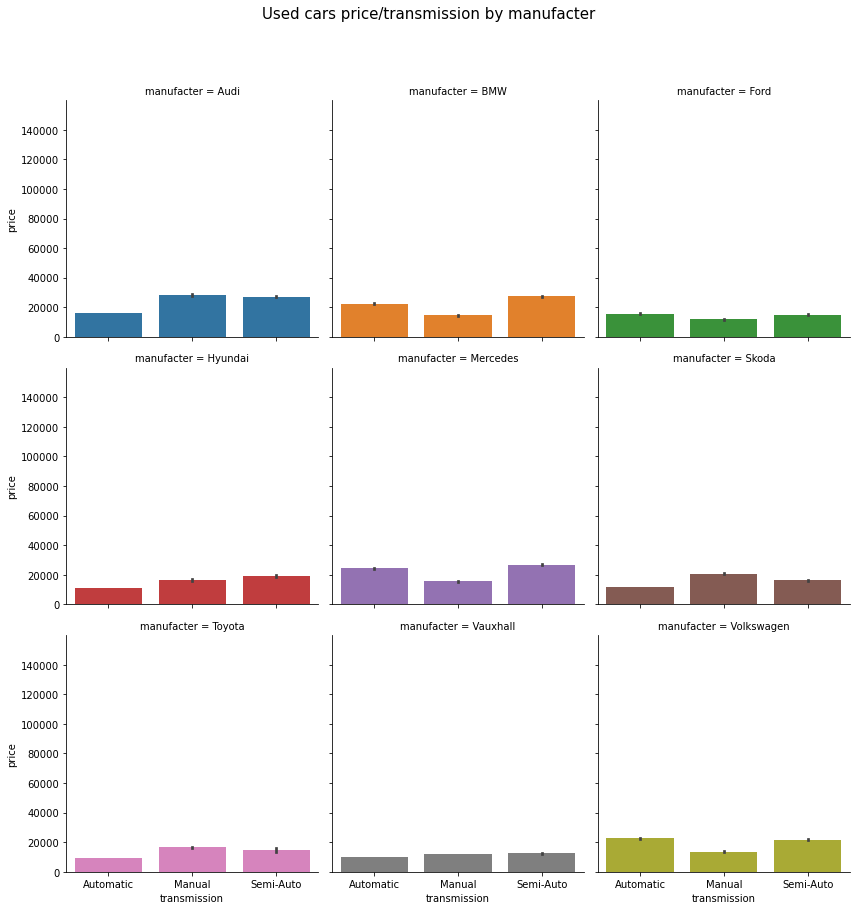

In [45]:
g = sns.FacetGrid(used_vehicles, col='manufacter', height=4, col_wrap=3, hue='manufacter')
g.fig.suptitle('Used cars price/transmission by manufacter', fontsize=15, y=1.05)
g.set(ylim=(0, used_vehicles.price.max()))
g.map(sns.barplot, 'transmission', 'price')

What is the impact of the mileage on the price ?

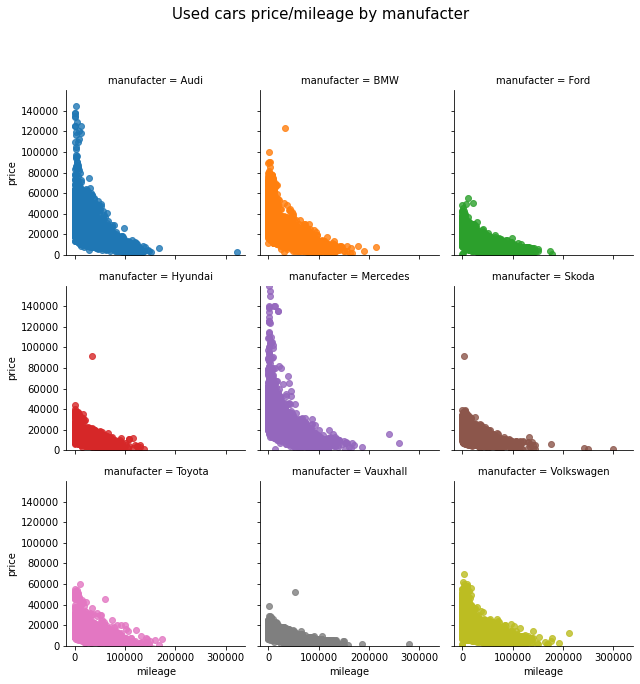

In [33]:
g = sns.FacetGrid(used_vehicles, col='manufacter', col_wrap=3, hue='manufacter')
g.fig.suptitle('Used cars price/mileage by manufacter', fontsize=15, y=1.05)
g.set(ylim=(0, used_vehicles.price.max()))
g.map(sns.regplot, 'mileage', 'price')

What is the impact of the fuel on the price ?

C:\Users\Acer\.conda\envs\training\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


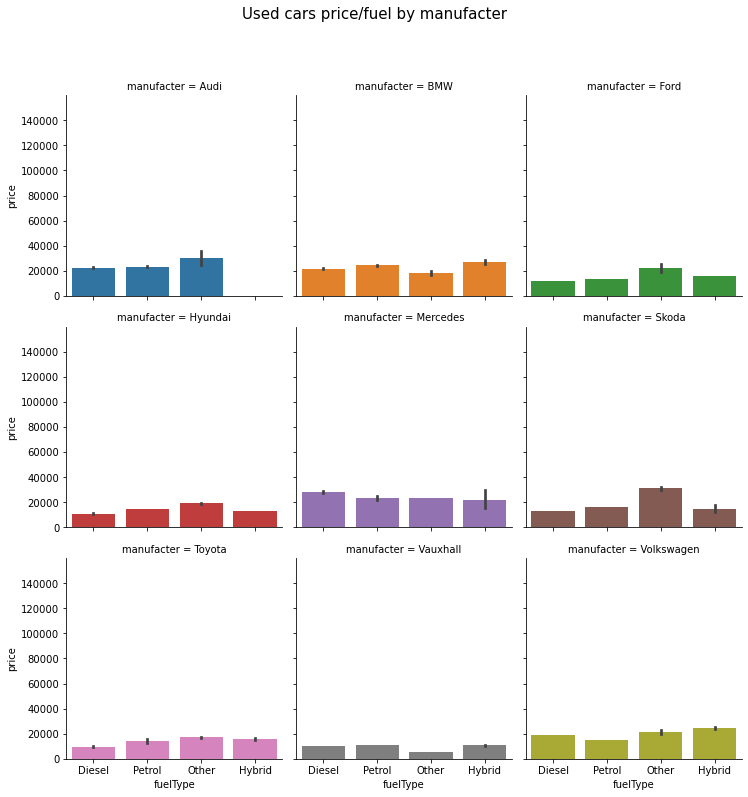

In [44]:
g = sns.FacetGrid(used_vehicles, col='manufacter', height=3.5, col_wrap=3, hue='manufacter')
g.fig.suptitle('Used cars price/fuel by manufacter', fontsize=15, y=1.05)
g.set(ylim=(0, used_vehicles.price.max()))
g.map(sns.barplot, 'fuelType', 'price')